# Copyright and Disclaimer 

This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. To view a copy of this license, visit [this page](http://creativecommons.org/licenses/by-nc-sa/4.0/) or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

The license gives you permission to copy, distribute and modify the code as you see fit provided that you credit me as author of whatever portions of the code you use, your work is intended for non-commercial purposes, and you retain the license in all your releases derived from this work.

The code below consists of an original implementation building upon the results of *Douven's Implementation.ipynb* to automate the simulation of the ABMs and extends functionality to model the hypothesized behavior of cosmologists measuring the value of the Hubble Constant. For an explanation of the purpose and functionality of the code, as well as an assessment of the results here reproduced, please refer to the report elsewhere in this repository.

# The Hegselmann-Krause Model with Noise 

$$
x_{i}(u+1)=\alpha \frac{1}{\left|X_{i}(u)\right|} \sum_{j \in X_{i}(u)} x_{j}(u)+(1-\alpha)(\tau+\operatorname{rnd}(\zeta))
$$

$$
X_{i}(u) :=\left\{j :\left|x_{i}(u)-x_{j}(u)\right| \leq \varepsilon\right\}
$$

1. $x_{i}(u)$ := opinion of agent $i$ after the $u$-th update.
2. $\epsilon$ := interval over which agents are willing to split the difference
3. $\alpha$ := weight given to accepted peers' opinion
4. $1 - \alpha$ := weight given to individual measurements of the data
5. $\tau$ := the true value of the parameter being mesaured
6. $\zeta$ := interval of statistical noise affecting individual measurements of data

# Core Functions 

In [1]:
# import necessary packages
using Distributions, Gadfly, Compose, DataFrames, StatsBase, Cairo
# set plot size
set_default_plot_size(20cm ,15cm)

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/sebastian/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
function hubble_updater(n_agents, n_steps, ϵ, α, τ, ζ, averaging)
    hk_ar = Array{Float64,2}(undef, n_agents, n_steps + 1)
    # toggle between pre 2001 beliefs and post Freedman 2001
    #hk_ar[:, 1] = rand(Uniform(50,90), n_agents)
    hk_ar[:, 1] = rand(Uniform(64,80), n_agents)
    for j in 1:n_steps, i in 1:n_agents
        fa = isapprox.(hk_ar[:, j], hk_ar[:, j][i], atol=ϵ)
        #hk_ar[i, j + 1] = α*averaging(hk_ar[:, j][fa]) + (1 - α)*max(0, min(1, τ + rand(Uniform(-ζ, ζ))))
        hk_ar[i, j + 1] = α*averaging(hk_ar[:, j][fa]) + (1 - α)*(τ + rand(Uniform(-ζ, ζ)))
    end
    return hk_ar
end

hubble_updater (generic function with 1 method)

In [3]:
# format array into a data frame and stacks it for plotting in Gadfly
function stack_dataset(hk_array)
    dframe = DataFrame(hk_array')
    names!(dframe, [Symbol("Agent $i") for i in 1:size(hk_array,1)])
    dframe = stack(dframe)
    dframe[:steps] = repeat(1:size(hk_array, 2), outer=size(hk_array, 1))
    return dframe
end

stack_dataset (generic function with 1 method)

In [ ]:
function hubble_plotter(hk_array)
    dframe = stack_dataset(hk_array)
    plot_result = plot(dframe, x=:steps, y=:value, color=:variable, Geom.point, Geom.line,
    Coord.cartesian(xmax=size(hk_array, 2) + 2.5),
    Guide.xlabel("Time Step"),
    Guide.ylabel("Believed True Value of  <i>H<sub>0</sub></i>"),
    Guide.title("Simulation results for the $collaboration collaboration"),
    yintercept=[τ], Geom.hline(style=:dot, color=colorant"black"),
    Guide.annotation(compose(context(), Compose.text(size(hk_array, 2) + 1 , τ - 0.5, "<i>H<sub>0</sub></i>"), font("DejaVu Mono"), fontsize(10pt))),
    Guide.annotation(compose(context(), Compose.text(42, 80 - 1, "n = $n"), font("DejaVu Mono"), fontsize(10pt))),
    Guide.annotation(compose(context(), Compose.text(42, 80 - 2, "ϵ = $ϵ"), font("DejaVu Mono"), fontsize(10pt))),    
    Guide.annotation(compose(context(), Compose.text(42, 80 - 3, "α = $α"), font("DejaVu Mono"), fontsize(10pt))),   
    Guide.annotation(compose(context(), Compose.text(42, 80 - 4, "τ = $τ"), font("DejaVu Mono"), fontsize(10pt))),                    
    Guide.annotation(compose(context(), Compose.text(42, 80 - 5, "ζ = $ζ"), font("DejaVu Mono"), fontsize(10pt))),                    
    Theme(key_position=:none, point_size=1.25pt,
        background_color=colorant"white",
        major_label_font="DejaVu Mono",
        minor_label_font="DejaVu Mono",
        major_label_font_size=12pt,
        minor_label_font_size=8pt),)
    return plot_result
end

In [4]:
function unbiased_conference(community, n_attendees, n_steps)
    # sample without replacement n_attendees from the community
    conference_attendees = community[sample(1:size(community,1), n_attendees, replace=false),:]
    # make the hegselmann-krause array and assign the initial value from the attendees
    hk_ar = Array{Float64,2}(undef, n_attendees, n_steps + 1)
    hk_ar[:,1] = conference_attendees[:,1]
    # define the attendees tolerance in terms of their respective telescope's uncertainty
    ϵ = conference_attendees[:,2]
    for j in 1:n_steps, i in 1:n_attendees
        # identify all neighbors within the individual agent's tolerance 
        fa = isapprox.(hk_ar[:, j], hk_ar[:, j][i], atol=ϵ[i]) # [dilate > 4 always converge]
        hk_ar[i, j + 1] = mean(hk_ar[:, j][fa])
    end
    return hk_ar
end

unbiased_conference (generic function with 1 method)

In [5]:
function biased_conference(community, n_attendees, n_steps, β)
    # sample without replacement n_attendees from the community
    conference_attendees = community[sample(1:size(community,1), n_attendees, replace=false),:]
    # make the hegselmann-krause array and assign the initial value from the attendees
    hk_ar = Array{Float64,2}(undef, n_attendees, n_steps + 1)
    hk_ar[:,1] = conference_attendees[:,1]
    # define the attendees' tolerance in terms of their respective telescope's uncertainty
    ϵ = conference_attendees[:,2]
    for j in 1:n_steps, i in 1:n_attendees
        # identify all neighbors within the individual agent's tolerance
        fa = isapprox.(hk_ar[:, j], hk_ar[:, j][i], atol=ϵ[i]) # dilate!!!
        # find all agents observing the same epoch as the current agent
        same = conference_attendees[:,3] .==  conference_attendees[i,3]        
        # find all agents observing a different epoch as the current agent
        diff = conference_attendees[:,3] .!=  conference_attendees[i,3]
        # find all agents within the tolerance AND observing the same epoch
        fa_same = fa .& same
        # find all agents within the tolerance AND observing a different epoch
        fa_diff = fa .& diff
        # Debugging showed NaNs. The solution involved a conditional
        # if the agent only finds agents within the tolerance observing the same epoch
        if (fa_same == fa)
        # proceed to pool opinions without bias
            hk_ar[i, j + 1] = mean(hk_ar[:, j][fa])
        else
        # otherwise pool opinions biased against agents observing different epochs
            hk_ar[i, j + 1] = β*mean(hk_ar[:, j][fa_same]) + (1 - β)*mean(hk_ar[:, j][fa_diff])
        end        
    end
    return hk_ar
end

biased_conference (generic function with 1 method)

In [6]:
#H_EW = 72.1; H_SW = 68.9;
function conference_plotter(hk_array, β)
    dframe = stack_dataset(hk_array)
    # check for bias
    if (β == 0)
        # make unbiased title
        title = "Simulation results for epoch unbiased conference (n = $n)"
    else
        # make biased title with β value
        title = "Simulation results for epoch biased conference (n = $n, β = $β)"
    end
    plot_result = plot(dframe, x=:steps, y=:value, color=:variable, Geom.point, Geom.line,
    Coord.cartesian(xmax=size(hk_array, 2) + 2.5),
    Guide.xlabel("Time Step"),
    Guide.ylabel("Believed True Value of  <i>H<sub>0</sub></i>"),
    Guide.title("$title"),
    #yintercept=[(H_SW - 0.5),H_SW,(H_SW + 0.5),(H_EW - 0.9),H_EW,(H_EW + 0.9)],
    #yintercept=[H_SW,H_EW],
    #Geom.hline(style=:dot, color=colorant"black"),
    #Guide.annotation(compose(context(), Compose.text(size(hk_array, 2) + 1 , H_EW - 1.0, "<i>H<sub>EW</sub></i>"), font("DejaVu Mono"), fontsize(10pt))),
    #Guide.annotation(compose(context(), Compose.text(size(hk_array, 2) + 1 , H_SW - 1.0, "<i>H<sub>SW</sub></i>"), font("DejaVu Mono"), fontsize(10pt))),
    Theme(key_position=:none, point_size=1.25pt,
        background_color=colorant"white",
        major_label_font="DejaVu Mono",
        minor_label_font="DejaVu Mono",
        major_label_font_size=12pt,
        minor_label_font_size=8pt),)
    return plot_result
end

conference_plotter (generic function with 1 method)

In [ ]:
function least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)
    sim_res = Array{Float64,3}(undef, n, t + 1, n_sim)
    for i in 1:n_sim
        sim_res[:, :, i] = hubble_updater(n, t, ϵ, α, τ, ζ, mean)
    end
    # find the least squares penalty of each agent at each step, in each simulation
    square_error = map(x->2*(x-τ)^2, sim_res)
    # average the penalties of all agents in each simulation
    average_agents = mean(square_error, dims=1)
    # average the penalties over all simulations at the
    # fifth step
    fifth_average = mean(average_agents[1,5,:])
    # tenth step
    tenth_average = mean(average_agents[1,10,:])
    # twenty-fifth step
    twentyfifth_average = mean(average_agents[1,25,:])
    # last step 
    last_average = mean(average_agents[1,t+1,:])
    res = [fifth_average, tenth_average, twentyfifth_average, last_average]
    return res
end


In [14]:
function draw_community()
    community = Array{Float64,2}(undef, 362, 3)
    # planck
    planck = hubble_updater(178,50,0.1, 0.9, 67.4, 0.5, mean)
    community[1:178,2] = fill(0.5,178,1)
    # des
    des = hubble_updater(96,50,0.1,0.9,67.4,1.15, mean)
    community[179:274,2] = fill(1.15,96,1)
    # shoes
    shoes = hubble_updater(15,50,0.1,0.9,74.0,1.4, mean)
    community[275:289,2] = fill(1.4,15,1)
    # cchp
    cchp = hubble_updater(13,50,0.1,0.9,69.8,1.9, mean)
    community[290:302,2] = fill(1.9,13,1)
    # miras
    miras = hubble_updater(11,50,0.1,0.9,73.6,3.9, mean)
    community[303:313,2] = fill(3.9,11,1)
    # holicow
    holicow = hubble_updater(26,50,0.1,0.9,73.3,1.75, mean)
    community[314:339,2] = fill(1.75,26,1)
    # mcp
    mcp = hubble_updater(15,50,0.1,0.9,74.8,3.1, mean)
    community[340:354,2] = fill(3.1,15,1)
    # sbf
    sbf = hubble_updater(8,50,0.1,0.9,76.5,4.0, mean)
    community[355:362,2] = fill(4.0,8,1)
    # distinguish epoch with booleans
    community[1:274,3,1] = trues(274,1)
    community[275:362,3,1] = falses(88,1)
    # assign values to first row
    community[:,1] = vcat(planck[:,end], des[:,end], 
        shoes[:,end], cchp[:,end], miras[:,end], holicow[:,end],
        mcp[:,end], sbf[:,end])
    return community
end

draw_community (generic function with 1 method)

In [8]:
function conference_simulations(n_attendees, n_steps, n_sim, β)
    unbiased_sims = Array{Float64,3}(undef, n_attendees, n_steps + 1, n_sim)
    biased_sims = Array{Float64,3}(undef, n_attendees, n_steps + 1, n_sim)
    for i in 1:n_sim
        current_community = draw_community()
        unbiased_sims[:,:,i] = unbiased_conference(current_community, n_attendees, n_steps)
        biased_sims[:,:,i] = biased_conference(current_community, n_attendees, n_steps, β)
    end
    return [unbiased_sims, biased_sims]
end

conference_simulations (generic function with 1 method)

# Observation Stage

### Difference-splitting

|   Team   | Epoch       | $n$ | $\epsilon$ | $\alpha$ |$\tau$|  $\zeta$    |
|----------|-------------|:---:|:----------:|:--------:|:----:|:-----------:|
| Planck   | early       | 178 |    0.1     |   0.9    | 67.4 | $[-0.5,0.5]$|
| DES+BBN  | early       | 96  |    0.1     |   0.9    | 67.4 | $[-1.2,1.1]$|
| SH0ES    | late        | 15  |    0.1     |   0.9    | 74.0 | $[-1.4,1.4]$|
| CCHP     | late        | 13  |    0.1     |   0.9    | 69.8 | $[-1.9,1.9]$|
| MIRAS    | late        | 11  |    0.1     |   0.9    | 73.6 | $[-3.9,3.9]$|
| H0LiCOW  | late        | 26  |    0.1     |   0.9    | 73.3 | $[-1.8,1.7]$|
| MCP      | late        | 15  |    0.1     |   0.9    | 74.8 | $[-3.1,3.1]$|
| SBF      | late        | 8   |    0.1     |   0.9    | 76.5 | $[-4.0,4.0]$|

#### Planck 

In [9]:
n = 178; t = 50; ϵ = 0.1; α = 0.9; τ = 67.4; ζ = 0.5;
collaboration = "Planck";
planck_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
planck_split_plot = hubble_plotter(planck_split)
draw(SVG("planck_split.svg", 20cm, 15cm), planck_split_plot)
draw(PDF("01_planck_split.pdf", 20cm, 15cm), planck_split_plot)

178×51 Array{Float64,2}:
 65.0699  65.2749  65.4763  65.6854  …  67.4777  67.4337  67.4113  67.4582
 77.7936  76.7819  75.8347  75.0001     67.3828  67.4417  67.4104  67.3803
 64.3063  64.6761  64.968   65.2116     67.3921  67.47    67.457   67.4382
 75.9426  75.0923  74.3554  73.6828     67.4393  67.4133  67.4481  67.4485
 69.055   68.9033  68.7168  68.5667     67.4539  67.3956  67.391   67.4161
 67.6967  67.7114  67.7276  67.7189  …  67.3963  67.3891  67.3929  67.4361
 71.1047  70.7938  70.4398  70.1641     67.4269  67.3836  67.3942  67.3962
 77.6341  76.6086  75.779   74.9912     67.4778  67.4149  67.4308  67.4223
 78.4816  77.3976  76.4257  75.5058     67.4462  67.4742  67.3756  67.3911
 69.8969  69.6782  69.4266  69.2233     67.4192  67.3935  67.4008  67.4192
 69.9644  69.6335  69.399   69.2473  …  67.4041  67.4242  67.4097  67.4568
 79.2645  78.0391  76.9795  76.0593     67.4025  67.4456  67.4319  67.3911
 78.7632  77.6113  76.6377  75.6931     67.4665  67.4663  67.4698  67.4157


#### Dark Energy Survey

In [10]:
n = 96; t = 50; ϵ = 0.1; α = 0.9; τ = 67.4; ζ = 1.15;
collaboration = "DES+BAO+BBN";
des_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
des_split_plot = hubble_plotter(des_split)
draw(SVG("des_split.svg", 20cm, 15cm), des_split_plot)
draw(PDF("03_des_split.pdf", 20cm, 15cm), des_split_plot)

96×51 Array{Float64,2}:
 65.2023  65.5409  65.8164  65.9677  …  67.3857  67.4015  67.3276  67.4576
 77.9543  76.7869  75.793   74.8796     67.4223  67.3215  67.2575  67.2935
 78.9072  77.7424  76.7589  75.7824     67.4047  67.5039  67.5052  67.3852
 79.516   78.2717  77.2801  76.2011     67.4597  67.3621  67.4338  67.4479
 71.1958  70.7365  70.3511  70.0264     67.329   67.2579  67.3946  67.3858
 65.0273  65.1812  65.5327  65.7875  …  67.318   67.4402  67.5278  67.5261
 64.8585  65.0476  65.1837  65.3639     67.3221  67.3123  67.4175  67.4427
 66.2669  66.5295  66.655   66.6084     67.4933  67.4667  67.36    67.3784
 79.5981  78.4262  77.2695  76.2641     67.3174  67.2508  67.3572  67.4042
 72.0603  71.6652  71.1735  70.8444     67.4342  67.3285  67.265   67.3078
 79.5833  78.3715  77.3664  76.4291  …  67.3652  67.4051  67.4476  67.4116
 68.0058  67.9758  68.0218  67.9611     67.3833  67.325   67.3966  67.319 
 75.22    74.4449  73.8499  73.2378     67.5218  67.5858  67.45    67.5367
 

#### SH0ES 

In [11]:
n = 15; t = 50; ϵ = 0.1; α = 0.9; τ = 74.0; ζ = 1.4;
collaboration = "SH0ES";
shoes_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
shoes_split_plot = hubble_plotter(shoes_split)
draw(SVG("shoes_split.svg", 20cm, 15cm), shoes_split_plot)
draw(PDF("05_shoes_split.pdf", 20cm, 15cm), shoes_split_plot)

15×51 Array{Float64,2}:
 74.4421  74.4967  74.5331  74.5162  …  73.7595  73.8127  73.818   73.8089
 69.1967  69.7144  70.2819  70.7127     74.0767  74.0354  74.1396  74.0604
 70.3248  70.6883  71.0463  71.2448     74.0142  73.9633  74.1047  74.0751
 72.3118  72.602   72.8049  72.9695     73.9974  73.9136  74.036   74.1461
 64.96    65.8648  66.543   67.1383     73.8803  74.0061  73.9168  74.0252
 69.7349  70.0923  70.5684  70.7955  …  73.9415  74.0651  74.0882  73.9457
 65.333   66.2257  66.9804  67.7096     74.0672  74.1582  73.9894  74.0385
 67.9106  68.6747  69.2676  69.822      73.9854  74.1308  74.1741  74.1536
 67.9843  68.6284  69.1649  69.6718     74.0583  74.0567  73.8905  73.7785
 76.1345  75.9095  75.6686  75.4585     74.0872  73.9624  74.017   74.0496
 64.7708  65.7569  66.4588  67.2274  …  73.8632  73.9768  73.9475  73.9942
 71.405   71.6545  71.9654  72.2205     74.0807  74.0645  73.914   73.9187
 73.1464  73.3309  73.3181  73.5191     73.8898  73.8984  73.8035  73.7655
 

#### CCHP 

In [12]:
n = 13; t = 50; ϵ = 0.1; α = 0.9; τ = 69.8; ζ = 1.9;
collaboration = "CCHP";
cchp_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#cchp_split_plot = hubble_plotter(cchp_split)
#draw(SVG("cchp_split.svg", 20cm, 15cm), cchp_split_plot)
#draw(PDF("07_cchp_split.pdf", 20cm, 15cm), cchp_split_plot)

13×51 Array{Float64,2}:
 68.413   68.5272  68.4788  68.795   …  69.719   69.5941  69.5618  69.4945
 70.5674  70.5113  70.4832  70.5612     69.7297  69.8604  69.9646  69.8812
 79.2636  78.4105  77.3831  76.5364     69.5323  69.7574  69.7798  69.6855
 71.7892  71.6436  71.5437  71.2858     69.893   69.7272  69.5889  69.5646
 72.6829  72.3757  72.1911  71.7867     69.7851  69.7513  69.589   69.6786
 76.3408  75.769   75.3432  74.7492  …  69.626   69.6052  69.7127  69.7905
 72.344   72.1363  71.8629  71.7462     69.7759  69.6155  69.4954  69.4435
 68.0638  68.0667  68.2589  68.2726     69.7825  69.651   69.637   69.7351
 75.7621  75.2386  74.7516  74.1753     69.7581  69.8503  69.7754  69.7766
 78.2668  77.5672  76.6566  75.9277     70.0876  70.1317  70.0238  69.9152
 76.4389  75.5963  75.0026  74.4291  …  69.7476  69.9219  70.0435  69.9631
 74.0698  73.7564  73.3132  73.0552     69.8007  69.69    69.5481  69.6961
 64.5619  64.9896  65.5217  65.8972     69.4894  69.6704  69.8716  69.8853

#### MIRAS

In [13]:
n = 11; t = 50; ϵ = 0.1; α = 0.9; τ = 73.6; ζ = 3.9;
collaboration = "MIRAS";
miras_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#miras_split_plot = hubble_plotter(miras_split)
#draw(SVG("miras_split.svg", 20cm, 15cm), miras_split_plot)
#draw(PDF("09_miras_split.pdf", 20cm, 15cm), miras_split_plot)

11×51 Array{Float64,2}:
 76.8695  76.5832  75.9413  75.5204  …  72.686   72.611   73.0561  73.3322
 65.7104  66.1438  66.8068  67.7116     74.313   74.2325  74.4118  74.3753
 74.0441  74.3688  74.5676  74.7343     74.3666  74.0962  73.895   74.2036
 66.5046  67.0258  67.4758  67.9492     73.4491  73.5369  73.873   74.0132
 73.7155  73.5719  73.468   73.0979     73.5688  73.6785  73.3095  73.2485
 75.9199  75.5692  75.1925  75.1978  …  74.7275  74.8837  75.093   75.019 
 69.8388  69.9253  70.5345  71.1324     72.9556  73.098   73.0082  73.185 
 64.1539  65.4424  66.4275  67.0608     73.2724  72.9232  73.0     73.1293
 74.6535  74.3128  74.4649  74.1595     74.1824  74.013   73.9163  73.8107
 64.9466  66.0655  66.9183  67.6924     73.1466  72.8627  72.6831  73.1443
 75.9232  75.7187  75.3211  75.1326  …  73.8411  73.6999  73.7543  73.3954

#### H0LiCOW 

In [14]:
n = 26; t = 50; ϵ = 0.1; α = 0.9; τ = 73.3; ζ = 1.75;
collaboration = "H0LiCOW";
holicow_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#holicow_split_plot = hubble_plotter(holicow_split)
#draw(SVG("holicow_split.svg", 20cm, 15cm), holicow_split_plot)
#draw(PDF("11_holicow_split.pdf", 20cm, 15cm), holicow_split_plot)

26×51 Array{Float64,2}:
 79.4565  78.8684  78.416   77.885   …  73.4276  73.2732  73.4373  73.5484
 68.4833  68.9624  69.3769  69.8339     73.2428  73.3253  73.2451  73.1641
 73.9483  74.0472  74.0065  74.0479     73.5502  73.4783  73.3302  73.2038
 65.1225  66.0856  66.9     67.4146     73.5306  73.3705  73.5088  73.4698
 77.3388  76.9744  76.7706  76.3598     73.2056  73.2823  73.3089  73.4444
 75.485   75.29    75.2631  75.1674  …  73.0442  73.1097  73.1096  72.9906
 68.6488  68.9532  69.2411  69.813      73.0005  72.8553  72.8255  72.7705
 78.7188  78.3491  77.8552  77.2786     72.9022  72.9159  73.1292  73.1608
 75.5155  75.1143  74.8466  74.6202     73.2845  73.1063  73.0859  72.9461
 72.9344  72.8675  72.8836  72.768      73.3497  73.4657  73.4833  73.4525
 66.7142  67.4645  68.1816  68.737   …  72.8685  73.0111  73.0137  73.0735
 64.2184  65.2611  66.0803  66.629      73.4689  73.3372  73.3512  73.3874
 76.0654  75.7015  75.3007  75.2209     73.5434  73.5973  73.6127  73.5915
 

#### MCP 

In [15]:
n = 15; t = 50; ϵ = 0.1; α = 0.9; τ = 74.8; ζ = 3.1;
collaboration = "MCP";
mcp_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#mcp_split_plot = hubble_plotter(mcp_split)
#draw(SVG("mcp_split.svg", 20cm, 15cm), mcp_split_plot)
#draw(PDF("13_mcp_split.pdf", 20cm, 15cm), mcp_split_plot)

15×51 Array{Float64,2}:
 64.1457  65.3531  66.4208  67.2798  …  75.0137  75.0405  75.1367  75.4118
 79.5574  79.1619  78.4179  77.9137     74.9119  74.6849  74.7301  74.9482
 67.3647  67.9109  68.5184  68.8513     74.84    74.9055  74.816   74.8877
 78.8476  78.587   78.0012  77.9888     74.9163  74.63    74.5126  74.4291
 71.8192  72.0674  72.0852  72.2799     74.2239  73.9883  74.0028  74.407 
 76.7133  76.6324  76.3215  75.8616  …  74.9526  75.1932  74.9068  74.6298
 72.0381  72.2583  72.2064  72.759      74.2102  74.313   74.663   74.4034
 66.245   66.7948  67.3335  68.2586     74.6911  74.7291  74.5857  74.8779
 66.4464  67.5152  68.017   68.7099     74.5662  74.3433  74.0514  73.8817
 67.5269  68.1346  68.6633  69.449      74.7888  74.7649  74.4726  74.226 
 75.7815  75.7115  75.8576  75.6343  …  75.4371  75.5407  75.7442  75.919 
 78.9215  78.4096  77.8827  77.4356     74.4643  74.279   74.4426  74.4283
 67.5439  68.3346  68.9512  69.3109     74.9429  75.0971  74.8218  75.1254
 

#### SBF

In [16]:
n = 8; t = 50; ϵ = 0.1; α = 0.9; τ = 76.5; ζ = 4.0;
collaboration = "SBF";
sbf_split = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#sbf_split_plot = hubble_plotter(sbf_split)
#draw(SVG("sbf_split.svg", 20cm, 15cm), sbf_split_plot)
#draw(PDF("15_sbf_split.pdf", 20cm, 15cm), sbf_split_plot)

8×51 Array{Float64,2}:
 69.3057  70.4148  71.0473  71.5717  …  76.908   77.0889  76.7582  76.4402
 75.3676  75.1654  74.993   75.0354     77.7648  77.9197  78.0666  77.7449
 76.2991  76.3846  76.5848  76.2484     77.2324  77.1537  77.1689  77.4172
 71.324   71.4502  72.2757  72.8977     76.3726  76.5342  76.489   76.4166
 69.0784  70.1668  70.6752  71.3211     76.1492  76.502   76.8617  76.6016
 78.5147  78.6478  78.7757  78.2462  …  76.7497  76.7943  76.48    76.1529
 66.1641  67.0047  67.648   68.7039     76.7402  76.7312  76.7333  76.8634
 75.4883  75.904   76.274   76.3396     76.3697  76.5789  76.8734  76.6965

# Data Collection -- No Difference Splitting

### No difference-splitting

|   Team   | Epoch       | $n$ | $\epsilon$ | $\alpha$ |$\tau$|  $\zeta$    |
|----------|-------------|:---:|:----------:|:--------:|:----:|:-----------:|
| Planck   | early       | 178 |    0.0     |   0.5    | 67.4 | $[-0.5,0.5]$|
| DES+BBN  | early       | 96  |    0.0     |   0.5    | 67.4 | $[-1.2,1.1]$|
| SH0ES    | late        | 15  |    0.0     |   0.5    | 74.0 | $[-1.4,1.4]$|
| CCHP     | late        | 13  |    0.0     |   0.5    | 69.8 | $[-1.9,1.9]$|
| MIRAS    | late        | 11  |    0.0     |   0.5    | 73.6 | $[-3.9,3.9]$|
| H0LiCOW  | late        | 26  |    0.0     |   0.5    | 73.3 | $[-1.8,1.7]$|
| MCP      | late        | 15  |    0.0     |   0.5    | 74.8 | $[-3.1,3.1]$|
| SBF      | late        | 8   |    0.0     |   0.5    | 76.5 | $[-4.0,4.0]$|

#### Planck 

In [15]:
n = 178; t = 50; ϵ = 0; α = 0.5; τ = 67.4; ζ = 0.5;
collaboration = "Planck";
planck_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#planck_nosplit_plot = hubble_plotter(planck_nosplit)
#draw(SVG("planck_nosplit.svg", 20cm, 15cm), planck_nosplit_plot)
#draw(PDF("02_planck_nosplit.pdf", 20cm, 15cm), planck_nosplit_plot)

#### Dark Energy Survey

In [17]:
n = 96; t = 50; ϵ = 0; α = 0.5; τ = 67.4; ζ = 1.15;
collaboration = "DES+BAO+BBN";
des_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
#des_nosplit_plot = hubble_plotter(des_nosplit)
#draw(SVG("des_nosplit.svg", 20cm, 15cm), des_nosplit_plot)
#draw(PDF("04_des_nosplit.pdf", 20cm, 15cm), des_nosplit_plot)

#### SH0ES 

In [19]:
n = 15; t = 50; ϵ = 0; α = 0.5; τ = 74.0; ζ = 1.4;
collaboration = "SH0ES";
shoes_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
shoes_nosplit_plot = hubble_plotter(shoes_nosplit)
#draw(SVG("shoes_nosplit.svg", 20cm, 15cm), shoes_nosplit_plot)
draw(PDF("06_shoes_nosplit.pdf", 20cm, 15cm), shoes_nosplit_plot)

#### CCHP

In [21]:
n = 13; t = 50; ϵ = 0; α = 0.5; τ = 69.8; ζ = 1.9;
collaboration = "CCHP";
cchp_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
cchp_nosplit_plot = hubble_plotter(cchp_nosplit)
#draw(SVG("cchp_nosplit.svg", 20cm, 15cm), cchp_nosplit_plot)
draw(PDF("08_cchp_nosplit.pdf", 20cm, 15cm), cchp_nosplit_plot)

#### MIRAS

In [26]:
n = 11; t = 50; ϵ = 0; α = 0.5; τ = 73.6; ζ = 3.9;
collaboration = "MIRAS";
miras_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
miras_nosplit_plot = hubble_plotter(miras_nosplit)
#draw(SVG("miras_nosplit.svg", 20cm, 15cm), miras_nosplit_plot)
draw(PDF("10_miras_nosplit.pdf", 20cm, 15cm), miras_nosplit_plot)

#### H0LiCOW 

In [27]:
n = 26; t = 50; ϵ = 0; α = 0.5; τ = 73.3; ζ = 1.75;
collaboration = "H0LiCOW";
holicow_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
holicow_nosplit_plot = hubble_plotter(holicow_nosplit)
#draw(SVG("holicow_nosplit.svg", 20cm, 15cm), holicow_nosplit_plot)
draw(PDF("12_holicow_nosplit.pdf", 20cm, 15cm), holicow_nosplit_plot)

#### MCP

In [28]:
n = 15; t = 50; ϵ = 0; α = 0.5; τ = 74.8; ζ = 3.1;
collaboration = "MCP";
mcp_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
mcp_nosplit_plot = hubble_plotter(mcp_nosplit)
#draw(SVG("mcp_nosplit.svg", 20cm, 15cm), mcp_nosplit_plot)
draw(PDF("14_mcp_nosplit.pdf", 20cm, 15cm), mcp_nosplit_plot)

#### SBF

In [6]:
n = 8; t = 50; ϵ = 0; α = 0.5; τ = 76.5; ζ = 4.0;
collaboration = "SBF";
sbf_nosplit = hubble_updater(n,t,ϵ, α, τ, ζ, mean)
sbf_nosplit_plot = hubble_plotter(sbf_nosplit)
#draw(SVG("sbf_nosplit.svg", 20cm, 15cm), sbf_nosplit_plot)
draw(PDF("16_sbf_nosplit.pdf", 20cm, 15cm), sbf_nosplit_plot)

# Conference Stage 

## Unbiased Conference 

$$
x_{i}(u+1)=\frac{1}{\left|Z_{i}(u)\right|} \sum_{j \in Z_{i}(u)} x_{j}(u)
$$

$$
Z_{i}(u) :=\left\{j :\left|x_{i}(u)-x_{j}(u)\right| \leq \zeta_i\right\}
$$

## Biased Conference 

$$
x_{i}(u+1)=\frac{\beta}{\left|M_{i}(u)\right|} \sum_{j \in M_{i}(u)} x_{j}(u)+ \frac{(1 - \beta)}{\left|\neg M_{i}(u)\right|} \sum_{j \in \neg M_{i}(u)} x_{j}(u)
$$

$$
M_{i}(u) :=\left\{j \in Z_{i}(u): m(x_{j}) = m(x_{i})\right\}
$$

$$
\neg M_{i}(u) :=\left\{j \in Z_{i}(u): m(x_{j}) \neq m(x_{i})\right\}
$$

$$
m(x_{i})=\left\{\begin{array}{ll}{1} & {\text { if } x_{i} \text { took early universe measurements }} \\ {0} & {\text { if } x_{i} \text { took late universe measurements }}\end{array}\right.
$$

In [ ]:
# make an unbiased dataset for implementation
# this will prevent interference with the predictions
toy_data = Array{Float64,2}(undef, 300, 3)
toy_data[:,1] = rand(Uniform(67.4,76.5), 300)
toy_data[1:100,2] = fill(0.5,100,1)
toy_data[101:200,2] = fill(0.2,100,1)
toy_data[201:300,2] = fill(0.8,100,1)
toy_data[1:150,3] = trues(150,1)
toy_data[151:300,3] = falses(150,1)
toy_data

In [ ]:
n = 100; t = 50; β = 0;
kavli_unbiased = unbiased_conference(cosmology_community, n, t)
kavli_unbiased_plot = conference_plotter(kavli_unbiased,β)
#draw(PDF("17_kavli_unbiased.pdf", 20cm, 15cm), kavli_unbiased_plot)

In [ ]:
n = 100; t = 50; β = 0.9;
kavli_biased = biased_conference(cosmology_community, n, t, β)
kavli_biased_plot = conference_plotter(kavli_biased,β)
#draw(PDF("18_kavli_biased.pdf", 20cm, 15cm), kavli_biased_plot)

In [ ]:
n = 100; t = 50; β = 0;
toy_unbiased = unbiased_conference(toy_data,n,t)
toy_unbiased_plot = conference_plotter(toy_unbiased,β)
#draw(PDF("19_toy_unbiased.pdf", 20cm, 15cm), toy_unbiased_plot)

In [ ]:
n = 100; t = 50; β = 0.9;
toy_biased = biased_conference(toy_data,n,t,β)
toy_biased_plot = conference_plotter(toy_biased, β)
draw(PDF("20_toy_biased.pdf", 20cm, 15cm), toy_biased_plot)

# Time for statistics 

## Observation Stage - Least Squares Penalties

### Difference Splitting

#### Planck 

In [152]:
n = 178; t = 50; ϵ = 0.1; α = 0.9; τ = 67.4; ζ = 0.5; n_sim = 100;
planck_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 36.34857491308348    
 12.67037980851868    
  0.5316069990484099  
  0.002803378340629784

#### DES

In [153]:
n = 96; t = 50; ϵ = 0.1; α = 0.9; τ = 67.4; ζ = 1.15; n_sim = 100;
des_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 36.56491832126155    
 12.765438750901346   
  0.5615211074406822  
  0.016535843919381597

#### SH0ES

In [154]:
n = 15; t = 50; ϵ = 0.1; α = 0.9; τ = 74.0; ζ = 1.4; n_sim = 100;
shoes_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 22.484040058153308  
  7.939444313535343  
  0.383522720311922  
  0.04594935377601977

#### CCHP 

In [155]:
n = 13; t = 50; ϵ = 0.1; α = 0.9; τ = 69.8; ζ = 1.9; n_sim = 100;
cchp_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 22.579799179113532  
  7.908317714673656  
  0.452461787955213  
  0.10407904244190247

#### Miras

In [156]:
n = 11; t = 50; ϵ = 0.1; α = 0.9; τ = 73.6; ζ = 3.9; n_sim = 100;
miras_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 21.256054875352607 
  7.915726426323001 
  0.8701786396368631
  0.5202182187963558

#### H0LiCOW

In [157]:
n = 26; t = 50; ϵ = 0.1; α = 0.9; τ = 73.3; ζ = 1.75; n_sim = 100;
holicow_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 18.573610348544232  
  6.4953818844679185 
  0.3637084976753196 
  0.07652121821143747

#### MCP

In [158]:
n = 15; t = 50; ϵ = 0.1; α = 0.9; τ = 74.8; ζ = 3.1; n_sim = 100;
mcp_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 24.77121510232876   
  8.947079674204675  
  0.6810736542574467 
  0.31805403337636146

#### SBF 

In [159]:
n = 8; t = 50; ϵ = 0.1; α = 0.9; τ = 76.5; ζ = 4.0; n_sim = 100;
sbf_split_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 36.84864453762008  
 13.311675240314507 
  1.0766627434350378
  0.5248697704525759

### No Difference-Splitting

#### Planck 

In [160]:
n = 178; t = 50; ϵ = 0; α = 0.5; τ = 67.4; ζ = 0.5; n_sim = 100;
planck_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 0.3891699588650929  
 0.055602985969318335
 0.05614797883687305 
 0.055689179571082964

#### DES

In [161]:
n = 96; t = 50; ϵ = 0; α = 0.5; τ = 67.4; ζ = 1.15; n_sim = 100;
des_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 0.6377066518566612 
 0.29704999378786345
 0.2908544314873206 
 0.29019850002785735

#### SH0ES

In [162]:
n = 15; t = 50; ϵ = 0; α = 0.5; τ = 74.0; ζ = 1.4; n_sim = 100;
shoes_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 0.6573994785868108
 0.434177652891984 
 0.4401466771136904
 0.4431210132238483

#### CCHP 

In [163]:
n = 13; t = 50; ϵ = 0; α = 0.5; τ = 69.8; ζ = 1.9; n_sim = 100;
cchp_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 1.0569631191988764
 0.804291433816053 
 0.8012162912452188
 0.8405993895469516

#### Miras

In [164]:
n = 11; t = 50; ϵ = 0; α = 0.5; τ = 73.6; ζ = 3.9; n_sim = 100;
miras_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 3.646827904162762 
 3.374415134865396 
 3.5019095171103807
 3.531640493375367 

#### H0LiCOW

In [165]:
n = 26; t = 50; ϵ = 0; α = 0.5; τ = 73.3; ζ = 1.75; n_sim = 100;
holicow_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 0.8577578574564538
 0.6714151342143988
 0.6747747801632918
 0.6734573113123815

#### MCP

In [166]:
n = 15; t = 50; ϵ = 0; α = 0.5; τ = 74.8; ζ = 3.1; n_sim = 100;
mcp_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 2.311291771260155 
 2.1214399461283535
 2.1687420132968946
 2.1049156049944995

#### SBF 

In [167]:
n = 8; t = 50; ϵ = 0; α = 0.5; τ = 76.5; ζ = 4.0; n_sim = 100;
sbf_nosplit_dts = least_squares_steps(n, t, ϵ, α, τ, ζ, n_sim)

4-element Array{Float64,1}:
 3.7296177934633543
 3.2846383902284293
 3.635862340085472 
 3.5348174176919605

## Conference Stage - Relative Frequencies

In [17]:
# simulate 100 times both types of conference sampling from the same community
conference_sims = conference_simulations(100,50,100,0.9)
# arrays
unbiased_sims = conference_sims[1]
biased_sims = conference_sims[2]
# sort around the last value for all simulations
unbiased_endstates = sort(unbiased_sims[:,end,:],dims=1)
biased_endstates = sort(biased_sims[:,end,:], dims=1)
# find how many unique states in each simulation
n_endstates_b = Array{Float64,1}(undef, 100)
n_endstates_u = Array{Float64,1}(undef, 100)
for i in 1:100
    n_endstates_u[i] = size(unique(unbiased_endstates[:,i]),1)
    n_endstates_b[i] = size(unique(biased_endstates[:,i]),1)
end
unique(n_endstates_u), unique(n_endstates_b)

([2.0, 3.0, 4.0, 1.0], [2.0, 3.0, 4.0])

In [32]:
# find the mode end-state of each simulation and the proportion of agents with that value
unbiased_modes = Array{Float64,2}(undef, 100,2)
biased_modes = Array{Float64,2}(undef, 100,2)
for i in 1:100
    unbiased_modes[i,1] = mode(unbiased_endstates[:,i])
    unbiased_modes[i,2] = 100 - size(filter(x -> x != mode(unbiased_endstates[:,i]),
            unbiased_endstates[:,i]),1)
    biased_modes[i,1] = mode(biased_endstates[:,i])
    biased_modes[i,2] = 100 - size(filter(x -> x != mode(biased_endstates[:,i]),
            biased_endstates[:,i]),1)
end
mean(unbiased_modes[:,1]),mean(unbiased_modes[:,2])

(67.51518972664891, 74.25)

In [33]:
mean(biased_modes[:,1]),mean(biased_modes[:,2])

(67.43227708130969, 73.76)

In [34]:
# find the relative frequency of unbiased simulation endstates
u1 = size(filter(x -> x == 1.0, n_endstates_u),1)
u2 = size(filter(x -> x == 2.0, n_endstates_u),1)
u3 = size(filter(x -> x == 3.0, n_endstates_u),1)
u4 = size(filter(x -> x == 4.0, n_endstates_u),1)
u1,u2,u3,u4

(1, 51, 35, 13)

In [21]:
u1 + u2 + u3 + u4 == 100

true

In [22]:
# find the relative frequency of biased simulation endstates
b1 = size(filter(x -> x == 1.0, n_endstates_b),1)
b2 = size(filter(x -> x == 2.0, n_endstates_b),1)
b3 = size(filter(x -> x == 3.0, n_endstates_b),1)
b4 = size(filter(x -> x == 4.0, n_endstates_b),1)
b1,b2,b3,b4

(0, 49, 49, 2)

In [23]:
b1 + b2 + b3 + b4 == 100

true

## Conference Stage Plots
To be more in line with the statistical results, the idea now will be to make a plot for each of the distinct end-states that were found. This makes for a much more robust display of the results.

### Unbiased Plots

In [110]:
# 1 distinct end-state
n = 100; t = 50; β = 0;
kavli_unbiased_1 = conference_plotter(unbiased_sims[:,:,25],β)
draw(PDF("17_kavli_unbiased_1.pdf", 20cm, 15cm), kavli_unbiased_1)

In [118]:
# 2 distinct end-states
n = 100; t = 50; β = 0;
kavli_unbiased_2 = conference_plotter(unbiased_sims[:,:,100],β)
draw(PDF("18_kavli_unbiased_2.pdf", 20cm, 15cm), kavli_unbiased_2)

In [120]:
# 3 distinct end-states
n = 100; t = 50; β = 0;
kavli_unbiased_3 = conference_plotter(unbiased_sims[:,:,50],β)
draw(PDF("19_kavli_unbiased_3.pdf", 20cm, 15cm), kavli_unbiased_3)

In [127]:
# 4 distinct end-states
n = 100; t = 50; β = 0;
kavli_unbiased_4 = conference_plotter(unbiased_sims[:,:,30],β)
draw(PDF("20_kavli_unbiased_4.pdf", 20cm, 15cm), kavli_unbiased_4)

### Biased Plots

In [38]:
# 2 distinct end-states
n = 100; t = 50; β = 0.9;
kavli_biased_2 = conference_plotter(biased_sims[:,:,69],β)
draw(PDF("21_kavli_biased_2.pdf", 20cm, 15cm), kavli_biased_2)

In [44]:
# 3 distinct end-states
n = 100; t = 50; β = 0.9;
kavli_biased_3 = conference_plotter(biased_sims[:,:,80],β)
draw(PDF("22_kavli_biased_3.pdf", 20cm, 15cm), kavli_biased_3)

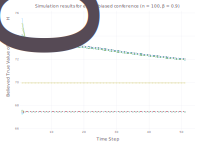

In [50]:
# 4 distinct end-states
n = 100; t = 50; β = 0.9;
kavli_biased_4 = conference_plotter(biased_sims[:,:,90],β)
#draw(PDF("23_kavli_biased_4.pdf", 20cm, 15cm), kavli_biased_4)

# THE END